## Objective
To extract windows around the spikes detected by the DL model

In [124]:
%load_ext autoreload
%autoreload

# Update PATH to allow imports
import sys
if "/data/MEAprojects/DLSpikeSorter" not in sys.path:
    sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from src.model import ModelSpikeSorter
from pathlib import Path

from tqdm import tqdm
from multiprocessing import Pool

from src.plot import set_ticks
from src.utils import random_seed

# from importlib import reload
# from src.analysis import standardize
# reload(standardize)
%autoreload 2
from src.analysis.standardize import count_spikes
from src.analysis.recording import Recording
from src.analysis.kilosort import Kilosort

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
# Load recording
REC_NAME = "2950"  # "2953"
REC_PATH = f"/data/MEAprojects/DLSpikeSorter/{REC_NAME}/data.raw.h5"  # .h5 path
# For bandpass filter
FREQ_MIN = 300
FREQ_MAX = 6000

# Load model
MODEL_PATH = Path(f"/data/MEAprojects/DLSpikeSorter/models/v0_4_4/{REC_NAME}/230101_133131_959516") # f"/data/MEAprojects/DLSpikeSorter/models/v0_4_4/{REC_NAME}/230101_133514_582221"
MODEL_SPIKE_TIMES_PATH = MODEL_PATH / "log/windows_200_120_spike_times.npy"
##
recording = Recording(REC_PATH, FREQ_MIN, FREQ_MAX, REC_NAME)
model = ModelSpikeSorter.load(MODEL_PATH)
model.spike_times = np.load(MODEL_SPIKE_TIMES_PATH, allow_pickle=True)

In [126]:
len(model.spike_times[338])

7232

In [4]:
num_windows = int((recording.rec_raw.get_num_samples() - 200) / 120 + 1) * 1020
num_samples = num_windows * 200
size = num_samples * 32 / 8e9
print(num_windows)
# windows = np.load("/data/MEAprojects/DLSpikeSorter/2950/windows_200_120.npy", mmap_mode="r")
# windows_size = 6119524000
# num_windows = 30597620

30596940


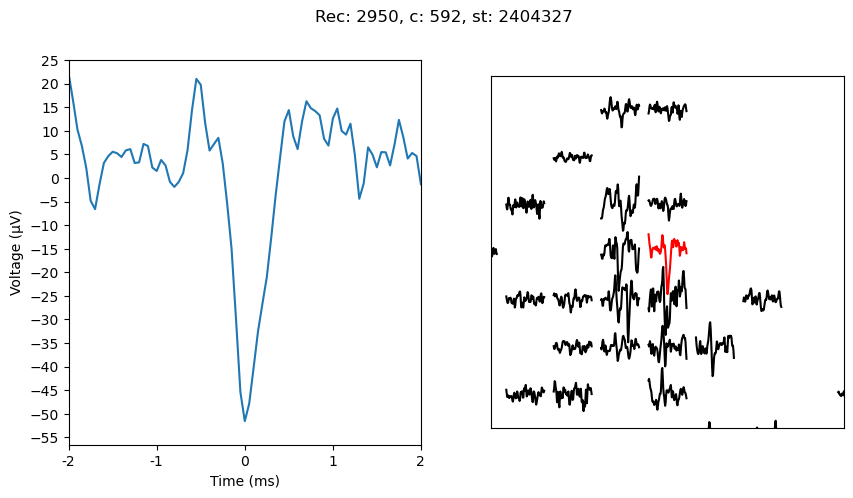

In [5]:
# Testing
ST = 2404327  # 2252695
recording.plot_waveform(ST, chan_center=None, n_before=40, n_after=40)

In [11]:
# Get a ks spike time
# np.load(f"/data/MEAprojects/DLSpikeSorter/{REC_NAME}/sorted.npz", allow_pickle=True)["spike_times"][10000]

2404327

In [6]:
# Estimate the size of the .npy array if all model's spikes are extracted
DTYPE_SIZE = 16  # Number of bits in dtype (i.e. 64 for float)
N_BEFORE = 60  # Number of frames before peak for extracted spikes
N_AFTER = 60  # Number of frames after peak for extracted spikes
##
# Count total number of model's spikes
num_model_spikes = sum(len(st) for st in model.spike_times)
num_channels = len(model.spike_times)
print(num_model_spikes)
print(f"Number of spikes: {num_model_spikes}")
num_bits = DTYPE_SIZE * num_model_spikes * num_channels * (N_BEFORE + 1 + N_AFTER)
print(f".npy size: {num_bits / 8e9:.2f} GB")

872024
Number of spikes: 872024
.npy size: 215.25 GB


## Investigation
Look at some examples of model's spike times, especially when same spike time exists on multiple channels

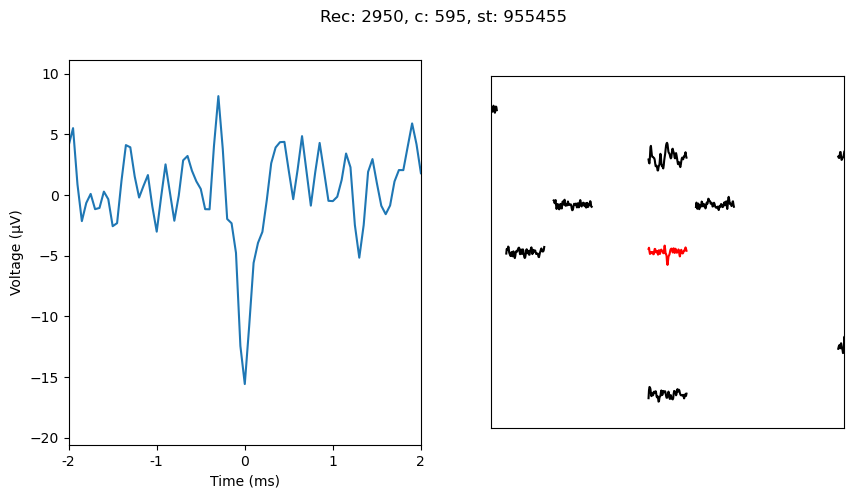

In [13]:
#
N_PLOTS = 1
np.random.seed(23)
##
for _ in range(N_PLOTS):
    st = None
    while st is None:
        chan = np.random.choice(len(model.spike_times))
        if len(model.spike_times[chan]) > 0:
            st = np.random.choice(model.spike_times[chan])
    recording.plot_waveform(st, chan_center=chan, n_before=40, n_after=40)

In [14]:
## Get which channels each spike time is detected on
model_st_chans = {}
for channel_idx, channel_spikes in enumerate(model.spike_times):
    for st in channel_spikes:
        if st not in model_st_chans:
            model_st_chans[st] = [channel_idx]
        else:
            model_st_chans[st].append(channel_idx)

In [15]:
## Count number of spike times that are same on multiple channels
num_model_spikes_repeated = sum(len(st)-1 for st in model_st_chans.values())
print(f"Total num model's spikes: {num_model_spikes}")
print(f"Number of spikes (no repeats): {len(model_st_chans)}")
print(f"Repeated num model's spikes: {num_model_spikes_repeated}")
print(f"Num of model's spikes detected on 1 channel: {num_model_spikes-num_model_spikes_repeated}")
print(f"Repeated/Total: {num_model_spikes_repeated/num_model_spikes * 100:.2f}%")

Total num model's spikes: 872024
Number of spikes (no repeats): 749840
Repeated num model's spikes: 122184
Num of model's spikes detected on 1 channel: 749840
Repeated/Total: 14.01%


In [147]:
## Plot distribution of number of spikes detected on each channel
spike_counts = [len(st) for st in model.spike_times]

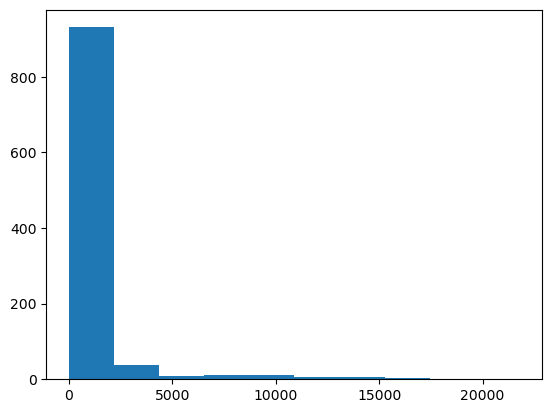

In [155]:
plt.hist(spike_counts)
plt.show()

2411607 [204, 489, 584]


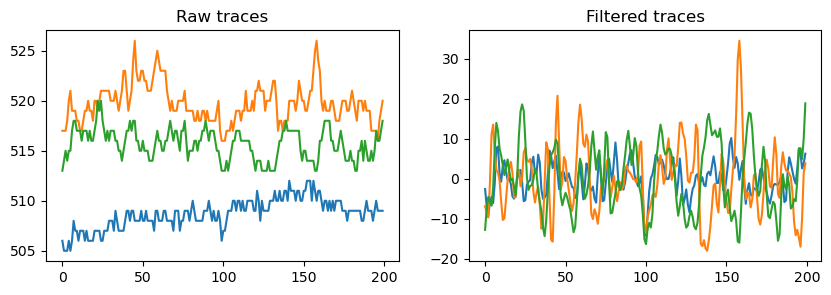

2866493 [106, 392, 398, 508]


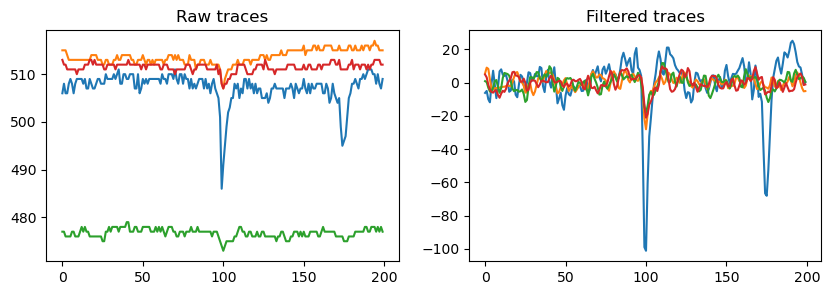

In [16]:
## Actually do some plotting
np.random.seed(231)
for _ in range(2):
    chans = None
    while chans is None or len(chans) < 3:
        st = np.random.choice(list(model_st_chans.keys()))
        chans = model_st_chans[st]

    print(st, chans)
    recording.plot_traces(st-100, st+100, chans)

## Investigation
Examine windows fed into model and model's output

In [3]:
# Load windows and model's outputs
WINDOW_STRIDE = 120
NUM_CHANNELS = 1020
REC_WINDOWS_PATH = f"/data/MEAprojects/DLSpikeSorter/{REC_NAME}/windows_200_{WINDOW_STRIDE}.npy"
MODEL_OUTPUTS_PATH = MODEL_PATH / f"log/windows_200_{WINDOW_STRIDE}_outputs.npy"
##
class RecordingWindows:
    """Class to represent windows fed into model of a recording and model's outputs"""
    def __init__(self, stride, num_channels, windows_path,
                 outputs_path):
        self.stride = stride
        self.num_chans = num_channels
        self.windows = np.load(windows_path, mmap_mode="r")
        self.outputs = np.load(outputs_path, mmap_mode="r")
        self.size_windows = self.windows.shape[-1]  # Size of windows
        self.size_outputs = self.outputs.shape[-1]  # Size of outputs

    def plot_window_output(self, idx, title=None,
                           subplots=None):
        # Plot window and model's output

        # Get data
        window = self.windows[idx].flatten()
        window -= np.mean(window)
        output = self.outputs[idx]

        # Set up plots
        if subplots is None:
            fig, (a0, a1) = plt.subplots(2, figsize=(6, 4))
        else:
            fig, a0, a1 = subplots
        axes = a0, a1
        for a in axes:
            a.set_xlim(0, self.size_windows)
        set_ticks(axes, window)

        if title is not None:
            a0.set_title(title)

        # Plot trace
        a0.plot(window)

        # Plot model's output
        output = torch.tensor(output)
        model.plot_loc_probs(output, a1)
        a1.set_title("")

        if subplots is None:
            plt.show()

    def time_to_window(self, time, chan_idx):
        """
        Find i such that self.windows[i] contains :param time: within the model output region
        on the channel :param chan_idx:

        time of beginning of window as a function of idx
            channel = idx % num_channels
            idx -= channel  # Idx if getting window for 0th channel
            # For every num_channels indices, there is an increase in time of stride
            time = idx / num_channels * stride

            # Test
            IDX = 677576
            NUM_CHANNELS = 1020
            STRIDE = 120
            FRONT_BUFFER = 40

            channel = IDX % NUM_CHANNELS
            idx = IDX - channel
            time = idx / num_channels * STRIDE

            time = int(time)
            rec_trace = recording.get_traces_raw(time, time+200, channel).flatten()
            window = rec_windows.windows[IDX].flatten()
            plt.plot(rec_trace)
            plt.plot(window)
            plt.show()
            np.all(rec_trace==window)

        :param time:
        :param chan_idx:
        :return: tuple
            0) idx
            1) offset: location of spike in window
        """
        assert self.stride == model.num_output_locs, "Not sure if time_to_window works if stride != model.num_output_locs"

        front_buffer = (self.size_windows - self.size_outputs) // 2

        idx_1_chan = max(0, time-front_buffer) // self.stride  # Index if getting recording only had 1 channel
        idx = idx_1_chan * self.num_chans + chan_idx

        window_start = idx_1_chan * self.stride  # Time of first frame in window
        offset = time - window_start

        return idx, offset

    def __len__(self):
        # Return number of windows
        return len(self.windows)

rec_windows = RecordingWindows(WINDOW_STRIDE, NUM_CHANNELS, REC_WINDOWS_PATH, MODEL_OUTPUTS_PATH)

In [4]:
## Assuming every spike is a false positive, find model's performance
print(f"Num spikes/Num windows: {num_model_spikes}/{len(rec_windows)} = {num_model_spikes/len(rec_windows) * 100:.2f}%")

NameError: name 'num_model_spikes' is not defined

True
2834593 95


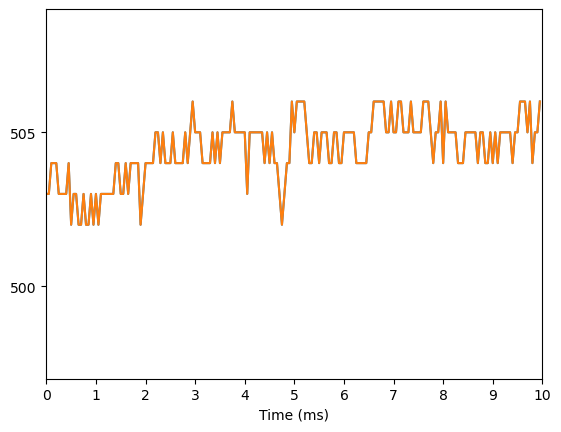

In [10]:
# Sanity check that RecordingWindows converts time to idx properly
CHAN_IDX = 13
ST = model.spike_times[CHAN_IDX][1]
##
ST = int(ST)
idx, offset = rec_windows.time_to_window(ST, CHAN_IDX)

trace_st = ST - offset
rec_trace = recording.get_traces_raw(trace_st, trace_st+rec_windows.size_windows, CHAN_IDX).flatten()
window = rec_windows.windows[idx].flatten()

print(np.all(window==rec_trace))
print(idx, offset)

fig, ax = plt.subplots(1)
ax.plot(rec_trace)
ax.plot(window)
set_ticks((ax,), rec_trace)
plt.show()

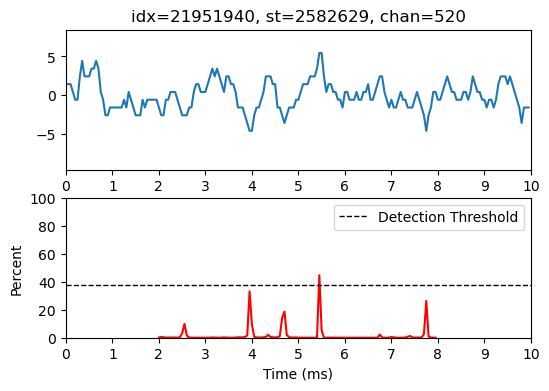

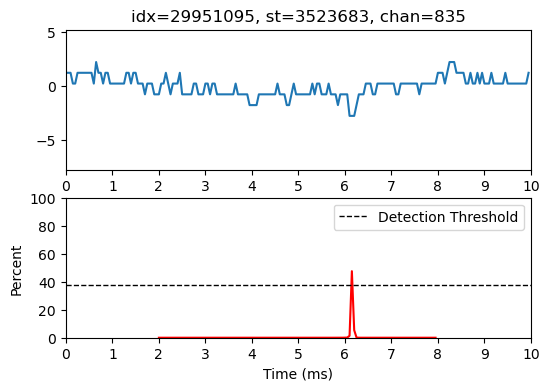

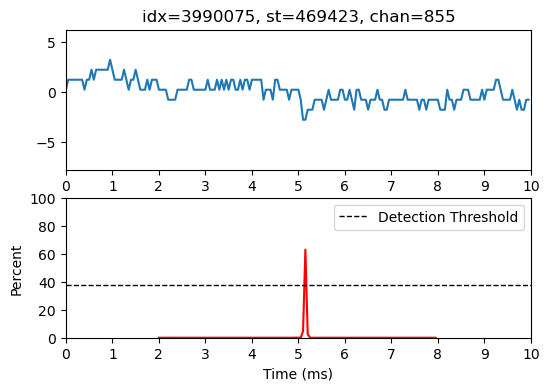

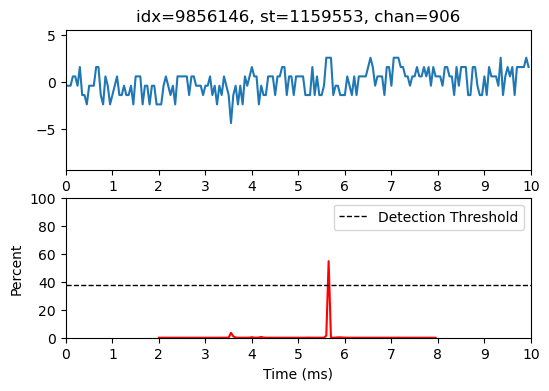

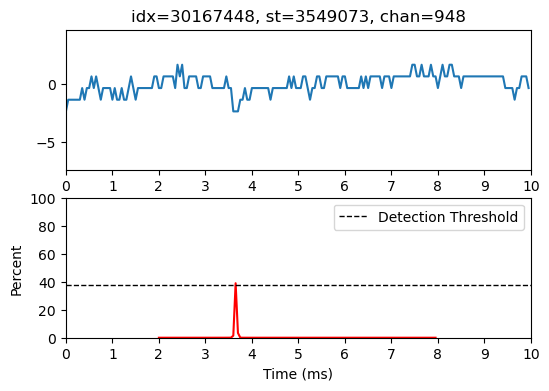

In [11]:
# Do some plotting
N_PLOTS = 5
np.random.seed(100)
##
for _ in range(N_PLOTS):
    while True:
        chan = np.random.choice(len(model.spike_times))
        if len(model.spike_times[chan]) > 0:
            st = np.random.choice(model.spike_times[chan])
            break
    idx, offset = rec_windows.time_to_window(st, chan)
    rec_windows.plot_window_output(idx, title=f"idx={idx}, st={st}, chan={chan}")

In [465]:
IDX = 9856146
##
window = rec_windows.windows[IDX].flatten()
output = rec_windows.outputs[IDX].flatten()

input_np = window[None, None, :]
input_torch = torch.tensor(input_np - np.mean(input_np, axis=2, keepdims=True), device="cuda")
with torch.no_grad():
    output_new = model(input_torch).detach().cpu().flatten()

## Investigation
Find distribution of number of predicted spikes in each input window to model

In [80]:
window_idx_count = {}  # {window_idx: num_spikes_in_window}
for chan, spike_times in enumerate(model.spike_times):
    for st in spike_times:
        window_idx = rec_windows.time_to_window(st, chan)[0]
        if window_idx not in window_idx_count:
            window_idx_count[window_idx] = 1
        else:
            window_idx_count[window_idx] += 1

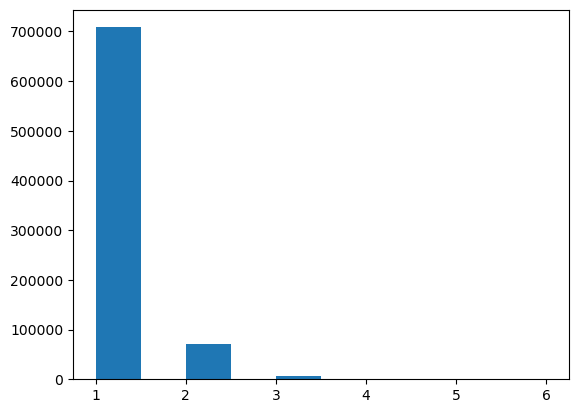

In [84]:
plt.hist(window_idx_count.values())
plt.show()

## Run Me
Get spikes detected by model and



In [5]:
##
set_spikes_model = set()  # Spikes detected by model
for chan, spikes in enumerate(tqdm(model.spike_times)):
    set_spikes_model.update(f"{chan}_{st}" for st in spikes)

100%|██████████| 1020/1020 [00:00<00:00, 1969.54it/s]


In [42]:
#  Get all spikes detected by kilosort
kilosort = Kilosort(recording_name=REC_NAME, curation_level="initial")
ks_spike_times = kilosort.curate_spike_times(max_chan_only=False,
                                             thresh_amp=30, thresh_std=None, thresh_rms=None)
##
set_spikes_ks = set()  # Spikes detected by kilosort
for chan, spikes in enumerate(tqdm(ks_spike_times)):
    set_spikes_ks.update(f"{chan}_{st}" for st in spikes)

100%|██████████| 1020/1020 [00:00<00:00, 287088.32it/s]


In [138]:
test = kilosort.curate_spike_times(max_chan_only=False, thresh_amp=5, thresh_std=None, thresh_rms=None)
len(test[338])

75

In [31]:
# Get all spikes detected by model
SPIKE_OVERLAP_BUFFER = 8  # If a spike is within SPIKE_OVERLAP_BUFFER of another spike, they are considered detected by
##
set_spikes_model_matched = set()  # Model's spikes also detected by kilosort
set_spikes_ks_matched = set()  # Kilosort's spikes also detected by model
for st_model in tqdm(set_spikes_model):
    st_model_chan, st_model_int = st_model.split("_")
    st_model_chan += "_"
    st_model_int = int(st_model_int)
    for st_model_buffer in range(st_model_int-SPIKE_OVERLAP_BUFFER, st_model_int+SPIKE_OVERLAP_BUFFER + 1):
        st_model_buffer = st_model_chan + str(st_model_buffer)
        if st_model_buffer in set_spikes_ks and st_model_buffer not in set_spikes_ks_matched:
            set_spikes_model_matched.add(st_model)
            set_spikes_ks_matched.add(st_model_buffer)
            break

100%|██████████| 872024/872024 [00:05<00:00, 160440.25it/s]


In [32]:
set_spikes_model_ks = set_spikes_model.difference(set_spikes_model_matched)
set_spikes_ks_model = set_spikes_ks.difference(set_spikes_ks_matched)

In [44]:
print(f"Spikes by model: {len(set_spikes_model)}")
print(f"Spikes by kilosort: {len(set_spikes_ks)}")
print(f"Matches: {len(set_spikes_model_matched)}")
print(f"Spikes by model and not kilosort: {len(set_spikes_model_ks)}")
print(f"Spikes by kilosort and not model: {len(set_spikes_ks_model)}")

Spikes by model: 872024
Spikes by kilosort: 6682
Matches: 6414
Spikes by model and not kilosort: 865610
Spikes by kilosort and not model: 268


## Run Me
Save spatial waveform plots of spikes that are detected by model and not kilosort, and vice vers

In [10]:
# Get total number and size of plots
KB_SIZE = 50  # Expected storage size of plots (in KB)
##
print(f"Total number of plots: {num_model_spikes}")
print(f"Total size of plots: {num_model_spikes * KB_SIZE * 1000 / 1e9} GB")

Total number of plots: 872024
Total size of plots: 43.6012 GB


In [13]:
class WaveformFigure:
    """
    Class for creating spatial waveform figures. Each figure is a 2x2 plot
    Top-left: bandpass filtered waveform
    Bottom-left: waveform spatial map
    Top-right: window input to model
    Bottom-right: model's location probabilities
    """

    def __init__(self, root_save_path, n_before, n_after):
        self.root_save_path = Path(root_save_path)
        self.n_before = n_before
        self.n_after = n_after

    def __call__(self, chan_st):
        chan, st = chan_st.split("_")
        chan = int(chan)
        st = int(st)
        save_path = self.root_save_path / f"{chan_st}.jpg"

        fig, ((a00, a01), (a10, a11)) = plt.subplots(2, 2, figsize=(7, 7), tight_layout=True)
        recording.plot_waveform(st, chan_center=chan, n_before=self.n_before, n_after=self.n_after,
                                subplots=(fig, (a00, a10)),
                                save_path=None, close_window=False)
        window_idx, st_offset = rec_windows.time_to_window(st, chan)
        rec_windows.plot_window_output(window_idx, subplots=(fig, a01, a11))

        # Show a00 in a01
        a01.axvline(st_offset-self.n_before, linestyle="dashed", alpha=0.8, color="gray")
        a01.axvline(st_offset+self.n_after, linestyle="dashed", alpha=0.8, color="gray")
        a01.axvline(st_offset, linestyle="dashed", alpha=0.5, color="red")

        # plt.show()

        fig.savefig(save_path)
        plt.close(fig)

In [14]:
# Set plots parameters
N_BEFORE = 40
N_AFTER = 40
## Some testing
# wf_figure = WaveformFigure(ROOT_FIGURE_SAVE_PATH, N_BEFORE, N_AFTER)
# import time
# start = time.time()
# i = 0
# N = 1
# while i < N:
#     if i >= N: break
#     for chan, spike_times in enumerate(model.spike_times):
#         if i >= N: break
#         for st in spike_times:
#             if i >= N: break
#             wf_figure(st, chan, i)
#             i += 1
# end = time.time()
# print(f"Time for {N} plots: {end - start} s")
# print(f"Expected time for all {num_model_spikes} plots: {num_model_spikes * (end-start) / N / 60} min")

In [35]:
def save_waveform_plots(spike_times, root_save_path, n_before=40, n_after=40):
    print("Saving images ...")
    with Pool(processes=16) as pool:
        wf_figure = WaveformFigure(root_save_path, n_before, n_after)
        for _ in tqdm(pool.imap(wf_figure, spike_times, chunksize=1), total=len(spike_times)):
            pass

In [ ]:
## See minimum time for saving all images
def _func(st):
    pass
print("Testing speed ...")
with Pool(processes=8) as pool:
    for _ in tqdm(pool.imap(_func, set_spikes_model_ks, chunksize=10), total=len(set_spikes_model_ks)):
        pass

In [ ]:
spikes_model_ks_shuffled = list(set_spikes_model_ks)
np.random.shuffle(spikes_model_ks_shuffled)
save_waveform_plots(spikes_model_ks_shuffled, MODEL_PATH / "log/wf_plots/model")

In [36]:
save_waveform_plots(set_spikes_ks_model, MODEL_PATH / "log/wf_plots/ks")

Saving images ...


100%|██████████| 268/268 [00:05<00:00, 45.67it/s]


In [ ]:
# For some reason, plt.close(fig) isn't actually closing figure
for _ in tqdm(range(100000)):
    fig, a0 = plt.subplots(1)
    a0.plot([0, 1, 2])
    plt.savefig("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2950/230101_133131_959516/log/wf_plots/delete_me.jpg")
    plt.close(fig)

## Investigation
Look at some spikes detected by kilosort and not model and vice versa

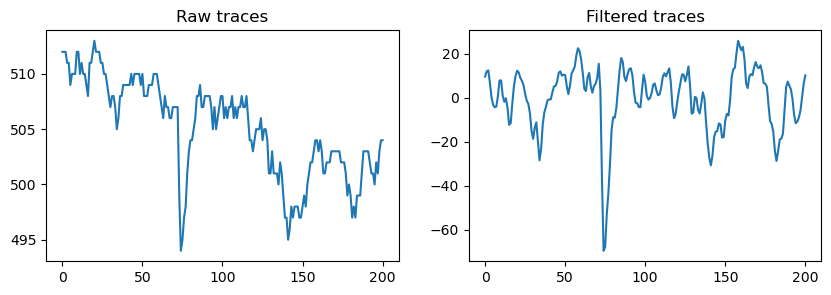

In [55]:
# Spike detected by kilosort and not by model
CHAN = 48
ST = 666361
recording.plot_traces(ST-100, ST+100+1, CHAN)

In [139]:
kilosort = Kilosort(REC_NAME, curation_level="initial")

In [ ]:
test = kilosort.curate_spike_times(max_chan_only=False)

In [149]:
test_c = test[322]  # model.spike_times[322]
idx = np.searchsorted(test_c, 2948990)
test_c[idx:idx+5]

[2962350, 2963214, 2965570, 2965655, 2965706]

In [ ]:
# Test if offset being caused by spikesort_matlab4 recentering
spike_times_recentered = kilosort.spike_times
spike_times_raw = kilosort.get_spike_times_raw()
st_idx = np.flatnonzero(spike_times_recentered == ST)[0]
print(f"Centered ST: {spike_times_recentered[st_idx]}")
print(f"Raw ST: {spike_times_raw[st_idx]}")
print(np.sum(spike_times_recentered != spike_times_raw))

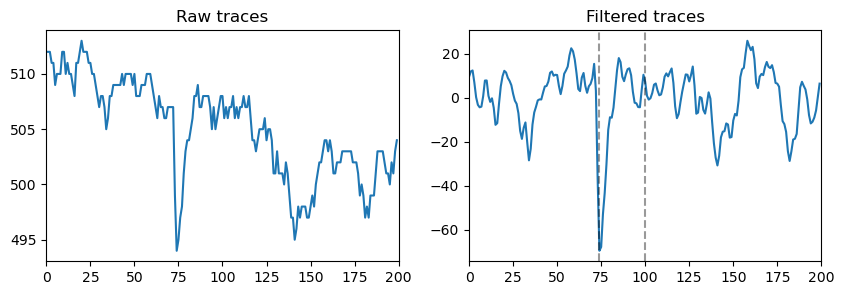

In [123]:
# Test if spike time being off is caused by spike time being correct on different channel
unit_id = kilosort.spike_clusters[st_idx]
template = kilosort.templates_mean[unit_id, :, :]
chan_max = template.min(axis=0).argsort()
fig, plots = recording.plot_traces(ST-100, ST+100, chan_max[:2], show=False)
for st in spike_times_recentered[st_idx-1:st_idx+1]:
    plots[1].axvline(st-ST+100, linestyle="dashed", color="black", alpha=0.4)
plt.show()

26


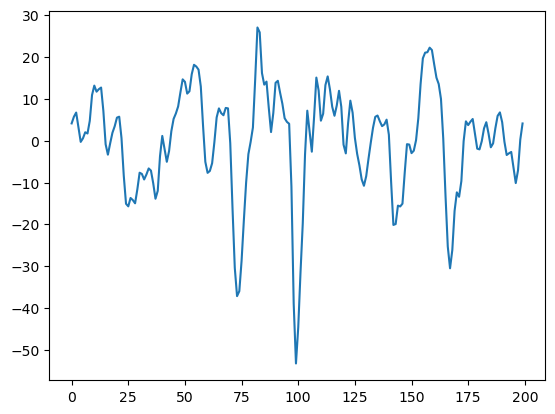

In [121]:
trace = recording.get_traces_filt(st-100, st+100, chan_max[1]).flatten()
from scipy.signal import find_peaks
peaks = find_peaks(-trace, height=33)[0]
plt.plot(trace)
print(peaks[1] - peaks[0])
plt.show()

In [85]:
spike_times_recentered[st_idx-5:st_idx+10]

array([666293, 666296, 666318, 666330, 666335, 666361, 666361, 666362,
       666368, 666380, 666397, 666399, 666400, 666405, 666406])

In [88]:
kilosort.spike_clusters[st_idx-5:st_idx+10]

array([43, 32, 38, 47, 55,  4, 53, 22, 52, 50, 39, 31, 23,  9, 21],
      dtype=uint32)

In [122]:
chan_max

array([  48, 1000,   60, ...,  494,  563,  343])

## Run Me
Extract waveform metrics for spikes detected by model and kilosort

In [21]:
from scipy.signal import find_peaks
def get_waveform_metrics(waveform, time_t, return_metrics=True):
    # If metrics, return metrics. Else, return points for plotting

    amp_t = waveform[time_t]

    time_p = time_t + np.argmax(waveform[time_t:]) # find_peaks(waveform[time_t:], height=0)[0][0]
    amp_p = waveform[time_p]

    temp_hp = waveform[time_p:]
    amp_hp =  amp_p / 2
    for i in range(temp_hp.size-1):
        y1 = temp_hp[i]
        y2 = temp_hp[i+1]
        if y1 >= amp_hp >= y2:
            time_hp = (amp_hp - y1) / (y2 - y1) + i + time_p
            break
    else:
        time_hp = waveform.size

    amp_ht = amp_t / 2
    time_ht2 = np.interp(amp_ht, waveform[time_t:time_p], range(time_t, time_p))

    time_pp = find_peaks(waveform[:time_t], height=amp_ht)[0][-1]  # Time of first positive peak before trough (pp for prepositive peak)--> time_pp to time_t is non-increasing
    time_ht1 = np.interp(-amp_ht, -waveform[time_pp:time_t], range(time_pp, time_t))

    if return_metrics:
        return time_ht2 - time_ht1, time_p - time_t, time_ht2 - time_t, time_hp - time_p, amp_p / amp_t
    else:
        return (time_ht1, amp_ht), (time_t, amp_t), (time_ht2, amp_ht), (time_p, amp_p), (time_hp, amp_hp)  # For plotting

In [19]:
ROOT_METRICS_SAVE_PATH = MODEL_PATH / "log/wf_metrics"
# For spike window
N_BEFORE = 40
N_AFTER = 40

Using random seed 146


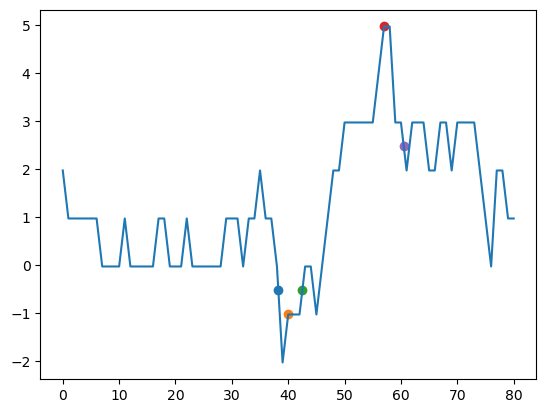

In [38]:
# Test get_waveform_metrics on ks_model spikes
N_PLOTS = 1
random_seed(146)
##
for _ in range(N_PLOTS):
    chan_st = np.random.choice(tuple(set_spikes_ks_model))
    chan, st = (int(x) for x in chan_st.split("_"))
    idx, offset = rec_windows.time_to_window(st, chan)
    window = rec_windows.windows[idx].flatten()
    window -= np.mean(window)
    waveform = window[offset-N_BEFORE: offset+N_AFTER + 1]

    plt.plot(waveform)
    for (x, y) in get_waveform_metrics(waveform, N_BEFORE, return_metrics=False):
        plt.scatter(x, y)
    plt.show()